In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tqdm

In [ ]:
class KMeans:
    def __init__(self, k, init='random', n_guess=10, max_iter=300, epsilon=1e-2):
        self.k_clusters = k
        self.init = init
        self.n_guess = n_guess
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.cluster_centers = None

    def _init_cluster_centers(self, xs):
        cc = np.array([])
        if self.init == 'random':
            idx = np.random.choice(range(xs.shape[0]), self.k_clusters, replace=False)
            cc = xs[idx]
        elif self.init == 'k-means++':
            init_idx = np.random.choice(range(xs.shape[0]))
            cc = np.array([init_idx], dtype=int)
            while len(cc) < self.k_clusters:
                squared_distances = np.linalg.norm(
                    xs[:, np.newaxis] - xs[cc][np.newaxis], axis=-1
                ).min(axis=-1) ** 2
                total_dis = squared_distances.sum()
                prob = squared_distances / total_dis
                cc = np.append(cc, np.random.choice(range(xs.shape[0]), p=prob))
            cc = xs[cc]
        return cc

    def predict(self, xs, cluster_centers=None):
        cluster_centers = self.cluster_centers if cluster_centers is None else cluster_centers

        # xs.shape: (n, ch), cluster_centers.shape: (k, ch)
        return np.linalg.norm(xs[:, np.newaxis] - cluster_centers[np.newaxis],
                              axis=-1).argmin(axis=-1)

    def score(self, cluster_centers, xs):
        distance = np.linalg.norm(
            xs[:, np.newaxis] - cluster_centers[np.newaxis], axis=-1
        ).min(axis=-1).sum()
        return distance

    def _update_center(self, cluster_centers, xs):
        idx = self.predict(xs, cluster_centers)
        new_centers = np.array([xs[idx == i].mean(axis=0) for i in range(self.k_clusters)])
        return new_centers

    def fit(self, xs):
        best, best_cc = -1, None
        for i in range(self.n_guess):
            cluster_centers = self._fit_single_run(xs, i)
            score = self.score(cluster_centers, xs)
            if best == -1 or score < best:
                best, best_cc = score, cluster_centers
        self.cluster_centers = best_cc
        return self

    def _fit_single_run(self, xs, rnd=0):
        cluster_centers = self._init_cluster_centers(xs)
        for _ in tqdm.trange(self.max_iter, desc=f'Round {rnd + 1}: '):
            new_cc = self._update_center(cluster_centers, xs)
            change = np.linalg.norm(new_cc - cluster_centers, axis=-1)
            converge = (change < self.epsilon).all()
            if converge:
                break
            cluster_centers = new_cc
        return cluster_centers


In [ ]:
image = cv2.imread('2-image.jpg')
image

In [ ]:
flatten_img = image.reshape((-1, 3))
flatten_img

In [ ]:
import time

start = time.time()
kmeans = KMeans(10, n_guess=50, max_iter=100, epsilon=1)
kmeans.fit(flatten_img)
print(f'{time.time() - start} secs')

In [ ]:
quantized_image = kmeans.cluster_centers[kmeans.predict(flatten_img)]
quantized_image = quantized_image.reshape(image.shape).astype(np.uint8)

plt.imshow(quantized_image[..., ::-1])

In [91]:
class MeanShift:
    def __init__(self, bandwidth, max_iter=100, epsilon=1e-2):
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.xs = None
        self.cluster_centers = None

    def predict(self, xs):
        # xs.shape: (n, ch), cluster_centers.shape: (k, ch)
        return np.linalg.norm(xs[:, np.newaxis] - self.cluster_centers[np.newaxis],
                              axis=-1).argmin(axis=-1)

    def fit(self, xs):
        self.xs = xs
        cluster_centers = []
        for x in tqdm.tqdm(xs, leave=False):
            cluster_centers.append(self._fit_one_seed(x))
        self.cluster_centers = cluster_centers
        self.remove_duplicate()
        return self

    def _fit_one_seed(self, x):
        kernel_mean = x
        for _ in range(self.max_iter):
            in_kernel = self._nearby(kernel_mean, self.xs)
            new_kernel = self.xs[in_kernel].mean(axis=0)
            if np.linalg.norm(new_kernel - kernel_mean) < self.epsilon:
                break
            kernel_mean = new_kernel
        return kernel_mean

    def remove_duplicate(self):
        # [TODO] remove the duplicated kernels that distance < bandwidth && has fewer points
        unique_centers = np.unique(np.array(self.cluster_centers, dtype=int), axis=0)
        points_in_kernels = np.array([self._nearby(center, self.xs).sum() for center in unique_centers])
        sorted_centers = unique_centers[points_in_kernels.argsort()[::-1]]

        mark = np.ones(sorted_centers.shape[0], dtype=bool)
        for i, center in enumerate(sorted_centers):
            if mark[i]:
                nearby = self._nearby(center, sorted_centers)
                mark[nearby] = False
                mark[i] = True
        self.cluster_centers = sorted_centers[mark]

    def _nearby(self, center, points):
        distances = np.linalg.norm(center[np.newaxis] - points, axis=-1)
        return distances < self.bandwidth

In [126]:
resized_image = cv2.resize(image, (0, 0), None, 0.3, 0.3)
flatten_resized_img = resized_image.reshape((-1, 3))

In [127]:
meanshift = MeanShift(30, max_iter=10, epsilon=1)

In [128]:
meanshift.fit(flatten_resized_img)

In [129]:
meanshift.cluster_centers

array([[ 50,  42,  29],
       [ 68,  59,  47],
       [ 98, 104, 110],
       [ 82,  76,  68],
       [109, 119, 135],
       [202, 206, 210],
       [119, 134, 160],
       [131, 150, 183],
       [186, 188, 189],
       [152, 171, 194],
       [182, 209, 234],
       [141, 172, 222],
       [ 12,   7,   5],
       [175, 253, 244],
       [  2,   2,  39],
       [ 29,  48, 118],
       [ 16,  28,  97]])

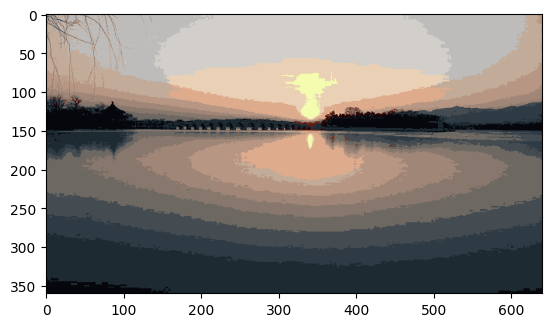

In [130]:
quantized_image = meanshift.cluster_centers[meanshift.predict(flatten_img)]
quantized_image = quantized_image.reshape(image.shape).astype(np.uint8)

plt.imshow(quantized_image[..., ::-1])

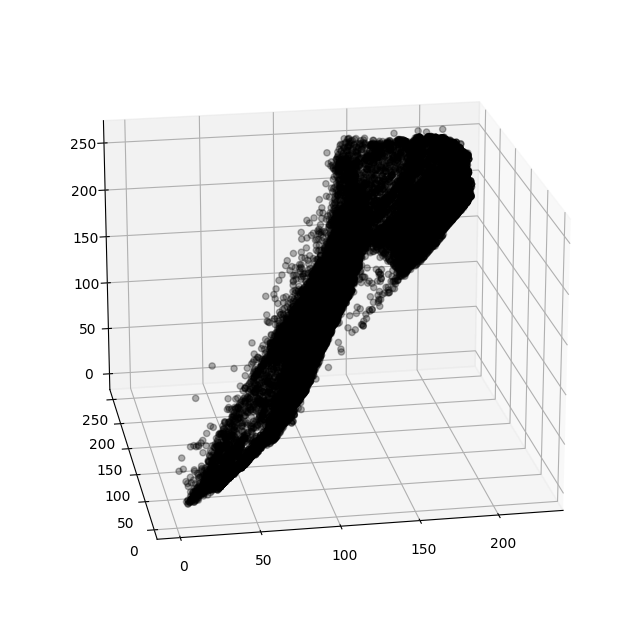

In [199]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    flatten_resized_img[:, 0],
    flatten_resized_img[:, 1],
    flatten_resized_img[:, 2],
    alpha=0.3, c='k')
ax.view_init(elev=20, azim=-100)


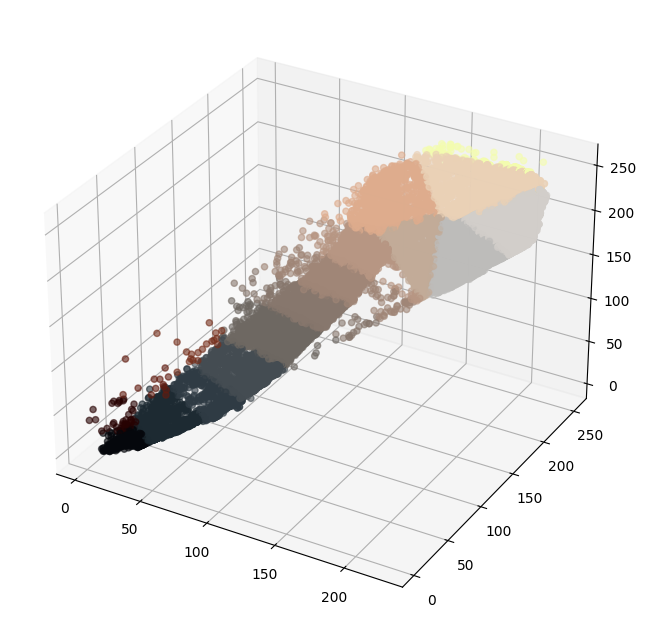

In [200]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
quantized_flat_img = meanshift.cluster_centers[
                         meanshift.predict(flatten_resized_img)
                     ].astype(float) / 255

ax.scatter(
    flatten_resized_img[:, 0],
    flatten_resized_img[:, 1],
    flatten_resized_img[:, 2],
    alpha=0.6, c=quantized_flat_img[..., ::-1])
# ax.view_init(elev=20, azim=-100)